In [36]:
import os
from torch.autograd import Variable
import torch.nn.functional as F
import torch.nn as nn
import torch.utils.data

import torch
from sklearn import preprocessing
import pandas as pd
import numpy as np

In [37]:
movies = pd.read_csv("./data/movies.csv")
ratings = pd.read_csv("./data/ratings.csv")

# %% [markdown]
# # A. showing some data

# %% [markdown]
# ## 5 first movies

In [38]:
movies.head(5)

# %% [markdown]
# # 5 last movies

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [39]:
movies.tail(5)

# %% [markdown]
# ## 5 first ratings

,movieId,title,genres
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation
9741,193609,Andrew Dice Clay: Dice Rules (1991),Comedy


In [40]:
ratings.head(5)

# %% [markdown]
# ## 5 last ratings

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [41]:
ratings.tail(5)

# %% [markdown]
# ## movies dataset shape

,userId,movieId,rating,timestamp
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352
100835,610,170875,3.0,1493846415


In [42]:
movies.shape

# %% [markdown]
# ## ratings dataset shape

(9742, 3)

In [43]:
ratings.shape

# %% [markdown]
# ### create a column in movie dataset

(100836, 4)

In [44]:

movies["list_index"] = movies.index

# %% [markdown]
# # B. merge the two datasets

In [45]:
df = pd.merge(movies, ratings, on="movieId")

In [46]:
df.head()

,movieId,title,genres,list_index,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0,1,4.0,964982703
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0,5,4.0,847434962
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0,7,4.5,1106635946
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0,15,2.5,1510577970
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0,17,4.5,1305696483


In [47]:
df.shape


# %% [markdown]
# # C. Delete the extra rows

# %% [markdown]
# title, genres and timestamp seems to have no use looking forward

(100836, 7)

In [48]:
df = df.drop(columns=["title", "genres", "timestamp", "list_index"])


In [49]:
df.head()

# %% [markdown]
# # D. Group by `userId`

,movieId,userId,rating
0,1,1,4.0
1,1,5,4.0
2,1,7,4.5
3,1,15,2.5
4,1,17,4.5


In [50]:
groups = df.groupby("userId")
groups.agg({
    "movieId": "count",
    "rating": "mean",

})


# %% [markdown]
# # E. Normalize the ratings


,movieId,rating
userId,,
1,232,4.366379
2,29,3.948276
3,39,2.435897
4,216,3.555556
5,44,3.636364
...,...,...
606,1115,3.657399
607,187,3.786096
608,831,3.134176


In [51]:
df[["rating"]]

,rating
0,4.0
1,4.0
2,4.5
3,2.5
4,4.5
...,...
100831,4.0
100832,3.5
100833,3.5
100834,3.5


In [52]:
scaler = preprocessing.StandardScaler()
train_x = scaler.fit_transform(df[["rating"]])
train_x

array([[ 0.47811176],
       [ 0.47811176],
       [ 0.95771699],
       ...,
       [-0.00149347],
       [-0.00149347],
       [ 0.47811176]])

In [53]:
# df["rating"] = train_x

In [54]:

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device= "cpu"
print(device)

cpu


In [55]:
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
# %%


def convert_to_output(row, user_rated_movie, user_id):
    movie_id = user_rated_movie.movieId.values
    if row in movie_id:
        return df.loc[(df.movieId == row) & (df.userId == user_id)].rating.values[0]
        # return
    else:
        return 0


def get_train_data():
    all_data = []
    for name, group in groups:
        print(name)
        rated_zero = pd.DataFrame(df.movieId.unique(), columns=["movieId"])
        # print(group)
        rated_zero["rating"] = rated_zero.movieId.apply(
            convert_to_output, user_rated_movie=group, user_id=name)
        all_data.append(rated_zero)
    return all_data


In [56]:
all_data = get_train_data()

# %% [markdown]
# # F. Build tne network

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [63]:


class RBM():
    def __init__(self, n_visible_layer, n_hidden_layer=20, lr=0.1):
        self.lr = lr
        self.W = nn.Parameter(torch.randn(
            (n_hidden_layer, n_visible_layer))*1e-2, requires_grad=False)
        self.a_bias = nn.Parameter(torch.randn(
            1, n_hidden_layer), requires_grad=False)
        self.r_bias = nn.Parameter(torch.randn(
            1, n_visible_layer), requires_grad=False)

    def forward(self, x):
        x = F.linear(x, self.W, self.a_bias)
        a = torch.sigmoid(x)
        return a

    def back(self, a):
        a = F.linear(a, self.W.t(), self.r_bias)
        x = torch.sigmoid(a)
        return x

    def sample_visible(a):
        return torch.bernoulli(a)

    def sample_hidden(x):
        return torch.bernoulli(x)

    def train(self, x, xp, a, ap):
        self.W += self.lr * (torch.mm(x.t(), a) - torch.mm(xp.t(), ap)).t()
        self.r_bias += self.lr * (x - xp)
        self.a_bias += self.lr * (a - ap)

    def loss(self, train, xp):
        indexes = train[train.rating != 0].index.values
        user_ratings = train[train.rating != 0].rating.values
        user_ratings = torch.tensor(user_ratings, dtype=torch.float)
        pred_ratings = xp[0, indexes]

        l = user_ratings - pred_ratings
        l = torch.pow(l, 2)
        l = torch.sum(l)
        return l


## G. Train for 20 epochs

In [91]:
n_visible_layer = df.movieId.unique().shape[0]
n_hidden_layer = 20
# predict_movie = RBM()
rbm = RBM(n_visible_layer=n_visible_layer,
          n_hidden_layer=n_hidden_layer, lr=0.1)
# train_op = optim.SGD(rbm.parameters(), 0.1)

total_loss = []
for epoch in range(20):
    loss = []
    for data in all_data:
        # print(data)
        rating = data.rating.values
        rating = torch.tensor(rating, dtype=torch.float)
        # print(len(rating))
        rating = Variable(rating.view(-1, len(rating)))

        a = rbm.forward(rating)
        rating_p = rbm.back(a)
        ap = rbm.forward(rating_p)
        rbm.train(rating, rating_p, a, ap)
        loss.append(rbm.loss(data, rating_p))
    total_loss.append(sum(loss))

    # print("Training loss for {} epoch: {}".format(epoch, np.mean(loss_)))


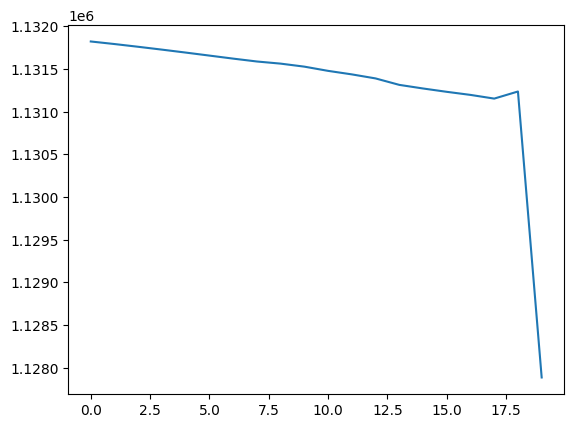

In [95]:
import matplotlib.pyplot as plt
plt.plot(total_loss)



In [93]:
sample_user = all_data[17]
rating = sample_user.rating.values
rating = torch.tensor(rating, dtype=torch.float)
rating = Variable(rating.view(-1, len(rating)))
a = rbm.forward(rating)
xp = rbm.back(a)
# %%

xp_numpy = xp.detach().numpy()
print(np.transpose(xp_numpy).shape)
sample_user["recom"] = np.transpose(xp_numpy).tolist()
sample_user["recom"] = sample_user['recom'].apply(lambda x: x[0])
# %%

sample_user.shape

(9724, 1)


(9724, 3)

In [94]:

non_rated = sample_user[sample_user.rating == 0]  # type: pd.DataFrame
non_rated = non_rated.sample(frac=1)
non_rated.nlargest(15, 'recom')

,movieId,rating,recom
217,253,0.0,1.0
472,539,0.0,1.0
315,357,0.0,1.0
2102,2797,0.0,1.0
3006,4027,0.0,1.0
1627,2174,0.0,1.0
123,150,0.0,1.0
3002,4022,0.0,1.0
3456,4720,0.0,1.0
901,1200,0.0,1.0
